# FIT5202: Assessment 2 : Sentiment Classification for Product Reviews
### Group Members
Monica | 29828775 <br>
Mukul Gupta | 29873150 <br>
Rachana Jobanputra | 29555248 <br>
#### Date: 31/10/2019

Version: 2.3.1

#### Environment: Python 3.6 and Jupyter notebook

#### Datasets : Yelp Reviews
labeled_data.csv (50k records)<br>
unlabeled_data.csv (600k records)<br>
test_data.csv (50k records)<br>

Run the following block of code when using google colab. Note: Change the path according to the drive

In [0]:
# #connecting to google drive
# from google.colab import drive
# import sys
# import os
# #Mount your Google drive to the VM
# drive.mount('/content/gdrive')
# sys.path.append('/content/gdrive/My Drive/')
# os.chdir("/content/gdrive/My Drive/")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


# Multi-label text classification using ULMFiT and FastAI Library in Python
# ULMFiT - Universal Language Model Fine Tuning

This method is one of the latest developments in the field of text classification in the hope that we can classify text much better. This concept focuses on understanding language rather than just text or words. ULMFiT makes use of transfer learning to create a Language Model. 


ULMFiT proposed by Jeremy Howard and NUI Galway Insight Center’s Sebastian Ruder, is capable of predicticting next word in the sentence  based on unsupervised learning of the WikiText 103 corpus. It uses multiple LSTM layers, with dropout applied to every layer which the secret behind this method. This was developed by Steve Merity (Salesforce) as the AWD-LSTM architecture. 

Main Reference -> https://medium.com/technonerds/using-fastais-ulmfit-to-make-a-state-of-the-art-multi-label-text-classifier-bf54e2943e83
<br>
Document for FastAI -> 
https://docs.fast.ai/text.data.html#TextLMDataBunch

In [0]:
from fastai.text import *
import pandas as pd
import numpy as np
from sklearn.feature_selection import chi2
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score

# Optional: use this line if you want to remove Pandas'
# default concatenation of long text in columns
pd.set_option('display.max_colwidth', -1)

__from sklearn.feature_selection import chi2:__
This score can be used to select the n_features features with the highest values for the test chi-squared statistic from X, which must contain only non-negative features such as booleans or frequencies (e.g., term counts in document classification), relative to the classes.

Chi square test tells you that which features are better related with the outcome variable. Smaller p value means more closely related with the outcome.

Reference -> https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html

## Loading the dataset in python and Spliting the dataset into Training and Validation Datasets:

In [0]:
data = pd.read_csv('labeled_data.csv')
data = data[['label','text']]
data.head()

,label,text
0,4,"The new rule is - \r\nif you are waiting for a table (which you almost always are) , you cant wait inside. \r\nThey just posted a sign upfront that it causes some concerns for the seated patrons. \r\nHow awful is that? \r\n\r\nI like that they included the apology along with ""especially now in the cold"". \r\n\r\np.s you can try calling in ahead to reserve a table but thats ONLY if the waiting list is short. Otherwise, you have to show up to reserve. Boourns. \r\n\r\n\r\nThis place could do no wrong in my eyes. Rattle away you equally-clever/witty-name-for a hot beverage.\r\n\r\nMust mention - I am obsessed with Mad Gab. \r\n\r\nxoxo\r\nM."
1,3,"Flirted with giving this two stars, but that's a pretty damning rating for what might have just been an off night...\r\n\r\nNew to the East side, and so we don't know many of these hidden gems, but me and the fiance met her friend for drinks here and ended up getting some things to nibble. \r\n\r\nFirst off, service was pretty slow, which was unusual because the restaurant is pretty small and galley style. You would think it would be easy for servers to routinely hit up tables as you pass by. \r\n\r\nThe fiance ordered the Quinoa Salad, and said it was pretty good, but dry. I wasn't too hungry and so I simply ordered the Bruchetta 3-way which came with burnt crostinis. And I ordered a side of fries, which were either hard or chewy.\r\n\r\nThe friend ordered the macaroni & cheese, and added chicken and bacon (her usual order) and liked it. \r\n\r\nCan't remember the last time I thought to myself- ""Huh... they failed at fries..."" So, like I said- two stars. But, the decor was good, it was a good place to have a conversation, and I might be back to try more expensive fare, but-... ah... the fry thing... yeeesh... I dunno, man..."
2,5,"I was staying at planet Hollywood across the street and saw good reviews on this place so my husband and I decided to give it a try. We love a good breakfast sandwich. We both ordered the bacon egg and cheese, cold brew, a biscuit and a salted caramel cookie. Everything tasted amazing! The egg is medium so it pops when you take a bite so be prepared for that. The cookie was absolutely delicious and the biscuit was soft and fluffy. We got there are around 10:30am and there was a line already. Luckily the line moves very quick and we were able to find seating. Highly recommend this place."
3,2,"Food is good but prices are super expensive. 8 bucks for the ""Extra Large"" Carne Asada burrito and it's a little bigger then a Taco Bell bean burrito. Don't get me wrong, it's good carne asada but you can get one at Filibertos and it's literally three times the size for 3 bucks.\r\n\r\nLower your prices or make the portions bigger - don't forget that you're using the cheapest cut of beef you can buy, marinating it with some orange juice, garlic and onions and then grilling it. We're not talking Foie gras and heirloom tomatoes. \r\n\r\nAnd seriously, one piece of cucumber and a quarter of a radish?\r\n\r\nI've gone there 4 or five times and each time do I'm left with the same opinion so here it is publicly."
4,1,Worse company to deal with they do horrible work had to bring my truck back on a door replacement the door paint didn't match and trim molding wasn't straight the bolt to keep the door on wasn't even tight. My speaker in the door wasn't hooked back up. I don't recommend anyone to bring the vehicle here. A gentleman by the name of Jesus that works there every time you call for an update because they say they will call you and never do he makes you feel like your bothering him and then he says he will call you back with an update and never do. If you need work on your vehicle I would double think it before you bring it here.


In [0]:
data = data.dropna()
data = data.reset_index(drop=True)

In [0]:
from sklearn.model_selection import train_test_split

df_trn, df_val = train_test_split(data, stratify = data['label'], test_size = 0.1, random_state = 5)
df_trn.shape, df_val.shape

((45000, 2), (5000, 2))

## Preparing/Preprocessing the Data:

Next, we will setup our data in the format that FastAI requires it to be in. FastAI provides simple functions to create Language Model and Classification "data bunch".<br><br>
Creating a data bunch automatically results in pre-processing of text, including vocabulary formation and tokenization. 
<br><br>
__TextLMDataBunch:__ creates a data bunch for language modelling. In this, labels are completely ignored. Instead, data is processed so that the RNN can learn what word comes next given a starting word. All the texts in the datasets are concatenated and the labels are ignored. Instead, the target is the next word in the sentence.

__TextClasDataBunch:__ sets up the data for classification. Labels play a key role here. We can also set the batch size for learning by changing the bs parameter. 


In [0]:
# Language model data
data_lm = TextLMDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = "")

# Classifier model data
data_clas = TextClasDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = "", vocab=data_lm.train_ds.vocab, bs=32)

__bs=32:__ is batch_size parameter. Usually, text databases are huge, so we need to feed these text into a GPU using batches, batch size 32 means that we will feed 32 texts at once to update parameters of our deep learning model. On running out of memory because of smaller GPU RAM, you can reduce batch size to 16. Here we have used Google Colab to execute our model hence bs=32. Also, training with large mini batches such as 128 or 256 might be bad.<br><br>
Reference -> https://towardsdatascience.com/transfer-learning-using-the-fastai-library-d686b238213e<br>
<br>
It is recommended to use smaller batch sizes if the GPU is not that large. Also, using larger batch sizes leads to lower train loss, but the test loss is comparatively larger. The test loss decreases if we decrease the batch size which is exactly what we want.<br> 
Research Paper -> https://arxiv.org/pdf/1803.09820.pdf

In [0]:
data_clas.show_batch()

text,target
"xxbos i am not a xxunk reviewer , in fact , i rarely do so . xxmaj however , the xxup second of two bad experiences really motivated me to do so due to the sheer arrogance of nonetheless - the owner ! xxmaj yes - the owner ! ! \r \n \r \n xxmaj first xxmaj negative xxmaj experience : xxmaj went on a xxmaj sunday with my",1
xxbos xxmaj if you 're ever involved in an accident in xxmaj las xxmaj vegas and the xxmaj nevada xxmaj highway xxmaj patrol calls for a tow truck there 's a good chance you 're going to get familiar with xxmaj custom xxmaj towing . xxmaj you 're not going to be happy with the experience because it 's going to cost you money you were not expecting to get,4
"xxbos xxmaj cactus xxmaj valley xxmaj pool xxmaj supply , i am xxup yelping on you xxrep 4 ! \r \n \r \n xxmaj first things first , you have until xxmaj june 30 , 2010 until my pool cleaning thingy warranty is up . xxmaj that means you only have until xxmaj june 30 , 2010 to win me back as a customer . \r \n \r \n",2
"xxbos xxmaj we booked our room through xxmaj priceline and , as our trip grew closer and we read the yelp reviews , i began to panic . xxmaj reports of dirty rooms , poor customer service , poor plumbing and shoddy service had me wondering if we 'd made the right choice . xxmaj below are the good and bad that led to our 3 star review : \r",3
"xxbos xxmaj first visit today , and i was not impressed by the food . xxmaj service was very good , xxunk look for xxmaj shea , and at least for this morning , he was at the bar / counter . i came in and was surprised by the number of people waiting outside ( it was very chilly ! ) , and even more amazed to see the",3


xx___ tags represent the aspects of language in a way that the computer can understand. <br><br>
__xxbos:__ marks the beginning of a sentence. <br>
__xxmaj:__ used to imply that the first letter of the next word is capitalized.<br>
__xxfld:__ represent separate parts of a document like title, summary etc., each one will get a separate field and so they will get numbered (e.g. xxfld 1, xxfld 2).<br>
__xup:__ if there's something in all caps, it gets lower cased and a token called xxup will get added to it. Words that are fully capitalized, such as “I AM SHOUTING”, are tokenized as “xxup i xxup am xxup shouting“.<br>
__xxunk:__ token used instead of an uncommon word.<br>
__xxrep:__ token indicates repeated word, if you have 29 ! in a row, (i.e. xxrep 29 !).<br><br>
Reference -> https://towardsdatascience.com/machine-learning-text-classification-language-modelling-using-fast-ai-b1b334f2872d


## Creating the Language Model:

In [0]:
# creating a language model with AWD-LSTM architecture mentioned above
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

__language_model_learner:__ creates a fast AI, language learner model.<br>
__data_lm:__ is the language model databunch created above.<br>
__AWD_LSTM:__ is the model architecture we are using here.<br>
__drop_mult:__ is the dropout. It is a hyper-parameter, used for regularization, sets the amount of dropout. If the model is over-fitting increase it, if under-fitting, you can decrease the number.
<br><br>

A single model can be used to simulate having a large number of different network architectures by randomly dropping out nodes during training. This is called dropout and offers a very computationally cheap and remarkably effective regularization method to reduce overfitting and improve generalization error in deep neural networks of all kinds.
<br>
Reference -> https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/


In [0]:
# !pip3 install https://download.pytorch.org/whl/cu80/torch-1.0.0-cp36-cp36m-linux_x86_64.whl

## Finding the Optimal Learning Rate to Train the Language Model:

__lr_find():__ Learning rate hyper-parameter is one of the most important parameters to train a model. Fast.ai provides a convenient utility (learn.lr_find) to search through a range of learning rates to find the optimum one for our dataset. Learning rate finder will increase the learning rate after each mini-batch. Eventually, the learning rate is too high that loss will get worse. <br>
Here, in the plot of Loss v/s Learning Rate, we first look at the lowest point and then going back one magnitude and choosing that as our learning rate. <br>
__learn.recorder.min_grad_lr:__ Here, this function, finds the optimum learning rate for us which is depicted by a red dot.
<br><br>
Reference -> https://towardsdatascience.com/machine-learning-text-classification-language-modelling-using-fast-ai-b1b334f2872d

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.59E-07
Min loss divided by 10: 1.74E-02


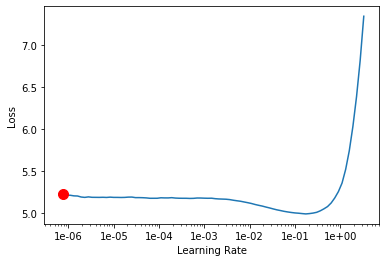

In [0]:
# finding the optimum learning rate
learn.lr_find()

# suggesting/capturing the optimum learning rate by plotting
learn.recorder.plot(suggestion=True)

# calculating the minimum gradient
min_grad_lr = learn.recorder.min_grad_lr

## Training the model with the Optimal Learning Rate:

__fit_one_cycle():__ Here we feed in the optimal learning rate to train our language model. First argument '2' is number of epoch runs.<br>
It trained last layers and basically left most of the model exactly as it was. But what we really want is to train the whole model. Normally after we fine-tune the last layers, the next thing we do is we go __unfreeze__ (unfreeze the whole model for training) and the again train the whole neural network.<br><br>

Reference -> https://towardsdatascience.com/machine-learning-text-classification-language-modelling-using-fast-ai-b1b334f2872d

In [0]:
# training the last few layers of the model
learn.fit_one_cycle(2, min_grad_lr)

epoch,train_loss,valid_loss,accuracy,time
0,5.162321,5.055027,0.214115,13:59
1,5.158807,5.050355,0.214454,14:01


In [0]:
# unfreezing the whole model
learn.unfreeze()

# training the rest of the neural network
learn.fit_one_cycle(2, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.816089,3.711027,0.305723,16:34
1,3.613280,3.599928,0.317626,16:34


Our language model only achieved around 30% accuracy. This accuracy represents how well the model does at predicting the next word, given one word.<br>

Accuracy = 0.3 means the model is guessing the next word of the movie review correctly about a third of the time. That sounds like a pretty high number. So it’s a good sign that our language model is doing pretty well.<br>

Hence, after fine-tuning we get a model that is good at understanding the reviews and we can fine-tune that with transfer learning to multi classify reviews. Finally, we save the language model encoder so that we can load it later in our classifier:

In [0]:
# saving the language model encoder
learn.save_encoder('ft_enc')

## Using the Language Model to train the Classifier:

__text_classifier_learner:__ built in fastai function used for training the text classifier. The first parameter is the __data_clas Databunch__. The second parameter is the __AWD_LSTM__ model architecture. For the third parameter drop_mult we have used 0.5. We have increased the dropout from 0.3 to 0.5 to prevent overfitting.

In [0]:
# training the text classifier using data_clas DataBunch we created earlier 
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)

# loading the model language encoder which we have saved earlier
learn.load_encoder('ft_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (45000 items)
x: TextList
xxbos xxmaj the pie was amazing . xxmaj do n't have anything bad to say about the pie . xxmaj my friend got fries and they were also good . xxmaj the 2 bad thing was they were running out of pies and the pie was a little smaller than i thought it would be . xxmaj but the pies are definitely worth trying,xxbos xxmaj food was alright , but way too expensive , and inexplicably late arriving as were the drinks ... xxmaj on a slow night . xxmaj what my real issue is here is the pushy and pompous waiter we had . xxmaj some hipster with a superiority complex and an attitude , ( younger fella with longer hair ) . xxmaj super pushy to the point you think they get paid commission . xxmaj ordered overpriced fries with their " chorizo gravy " which i 'm pretty sure was xxmaj hormel chili out the can ... xxmaj tasted that way anyway . xxmaj price point here is outrageous given their awful service and lackluster quality .

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-02
Min loss divided by 10: 2.09E-02


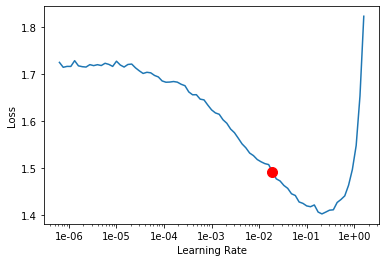

In [0]:
# again finding the optimal learning rate
learn.lr_find()

# ploting the optimal learning rate
learn.recorder.plot(suggestion=True)

# again calculating the minimum gradient
min_grad_lr = learn.recorder.min_grad_lr

In [0]:
# again training our language model by feeding in the optimal learning rate with 2 epochs
learn.fit_one_cycle(2, min_grad_lr)

epoch,train_loss,valid_loss,accuracy,time
0,1.027914,0.933430,0.591000,08:01
1,1.015275,0.898150,0.609800,07:03


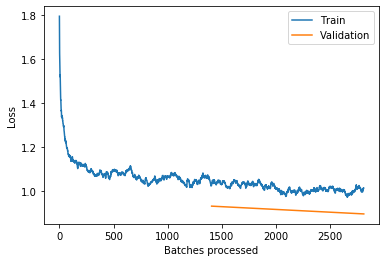

In [0]:
# tracking the loss functions over the epochs
learn.recorder.plot_losses()

__fit_one_cycle():__  It is one cycle of learning rate. When we call fit_one_cycle, we are actually passing in a maximum learning rate. On getting close to the final answer it is needed to anneal the learning rate to hone in on it. The motivation behind this is that during the middle of learning when learning rate is higher, the learning rate works as regularization method and keep network from over-fitting. This helps the network to avoid steep areas of loss and land better flatter minima.<br><br>

Reference -> https://towardsdatascience.com/machine-learning-text-classification-language-modelling-using-fast-ai-b1b334f2872d

__Discriminative Leraing Rates | slice():__ These are the techniques fast.ai uses underneath for such impressive results, applying different learning rate to layers as we go from layer to layer. When fitting a model you can pass a list of learning rates which will apply a different rate to each layer group. On passing slice(start,end) then the first group's learning rate is start, the last is end, and the remaining are evenly spaced.<br>
The bottom of the slice and the top of the slice is the difference between how quickly the lowest layer of the model learns versus the highest layer of the model learns. As you go from layer to layer, we decrease the learning rate. The lowest levels are given smaller learning rates so as not to disturb the weights much.<br><br>

Reference -> https://towardsdatascience.com/machine-learning-text-classification-language-modelling-using-fast-ai-b1b334f2872d

__Momentum:__ The argument(moms=(0.8,0.7)), momentums equals 0.8,0.7. Basically for training recurrent neural networks (RNNs), it really helps to decrease the momentum a little bit. Every time our learning rate is small, our momentum is high, as we are learning small learning rate, but we keep going in the same direction, we may as well go faster (higher momentum). But as we are learning at a high learning rate, but we keep going in the same direction, we might overshoot the target, so momentum should be slowed. This trick can help anyone train 10 times faster.

__freeze_to:__ Not unfreezing the whole thing but to unfreeze one layer at a time. Hence, unfreezing the last two layers __freeze_to(-2)__, training it a little bit more and then unfreeze the whole thing __unfreeze()__, train it a little bit more. This approach works very well and gives incredible results.

In [0]:
# gradual unfreezing
# start by training the last few layers, then go backwards and unfreeze and train layers before.
# here, we unfreeze the last 2 layers
learn.freeze_to(-2)

# training the language model
learn.fit_one_cycle(3, slice(5e-3, 2e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.923494,0.851291,0.626800,08:22
1,0.853407,0.794165,0.652200,10:10
2,0.830406,0.786319,0.654600,08:55


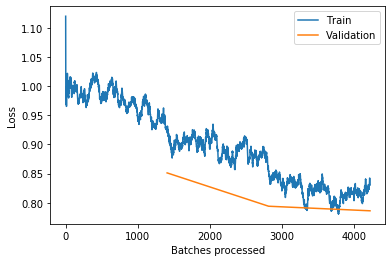

In [0]:
learn.recorder.plot_losses()

In [0]:
learn.unfreeze()
learn.fit_one_cycle(3, slice(2e-3/100, 2e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.808249,0.784617,0.664000,17:04
1,0.767000,0.765225,0.670400,20:53
2,0.668723,0.776251,0.670600,18:50


## Analyzing the Results:

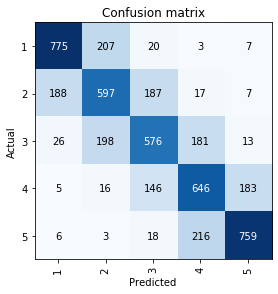

In [0]:
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)
interp.plot_confusion_matrix()

The diagonal represent correct predictions and the bright blue represents that these boxes have a high value compared to the rest of the boxes. This means that our classifier was able to correctly classify most of the test set correctly.

In [0]:
# finding the categories that the classifier gets confused on the most
interp.most_confused()

[(5, 4, 216),
 (1, 2, 207),
 (3, 2, 198),
 (2, 1, 188),
 (2, 3, 187),
 (4, 5, 183),
 (3, 4, 181),
 (4, 3, 146),
 (3, 1, 26),
 (1, 3, 20),
 (5, 3, 18),
 (2, 4, 17),
 (4, 2, 16),
 (3, 5, 13),
 (1, 5, 7),
 (2, 5, 7),
 (5, 1, 6),
 (4, 1, 5),
 (1, 4, 3),
 (5, 2, 3)]

# F score

In [0]:
f1_score(interp.pred_class, interp.y_true, average="macro")

0.6707022008291188

# Recall

In [0]:
recall_score(interp.pred_class, interp.y_true, average="macro")

0.6717906298020541

# Precision

In [0]:
precision_score(interp.pred_class, interp.y_true, average="macro")

0.6701528271316899

# Accuracy

In [0]:
accuracy_score(interp.pred_class, interp.y_true)

0.6706

## Predicting the labels of the Test Data:

In [0]:
test_data = pd.read_csv('test_data.csv')
test_data.head()

,test_id,text
0,test_1,trying to have a nice quiet dinner. the announcer for the awards giveaways is way too loud in the restaurant
1,test_2,"Been getting food to go from here for over 3yrs. My wife usually tend to get the same items. Why fix something when it works.\r\n\r\nShe always gets the Mongolian Beef lunch special, or dinner. Every once in a while we indulge in the Crab Rangoon. I tend to alternate between the Singapore Noodle, Chicken Fried Rice and the Chow Mai Fun.\r\n\r\nIt's not the best Chinese food I've had, but I never had a complaint regarding the quality and quantity of my food. I've never had to wait longer then 10 mins to pick up my food as well.\r\n\r\nThey recently raised the price on their lunch specials by $0.50, but it is still a killer deal at $5.49.\r\n\r\nGood food, good prices."
2,test_3,"Ugh. I've had to eat here a couple of times because of work events. This of course makes the scantily clad girls super awkward...\r\nIf you're vegan there is not much you can eat. You're looking at an overpriced salad that you've negotiated with the server to make sure you're getting food at all. I called ahead and planned something out with the manager, who was pretty helpful. But it did still mean I was paying a ridiculous amount of $$ for lettuce and a couple of strawberries. And for the most part they are terrible when dealing with people with dietary considerations:\r\n1. I ordered a salad and asked for no meat or cheese. You'd think they would put more of the other ingredients in it to compensate, but no - so I was essentially eating just lettuce with a very very sparse sprinkling of nuts. ALSO they served it WITH THE MEAT! and then clearly just took off the meat and gave it back to me instead of making a new one. EW. The manager apologized and said it wouldn't be charged - very nice. However, this didn't get communicated to the server who DID charge me for it!\r\n2. Their ""vegetarian green beans"" are made with beef broth! When I told the person that that wasn't ""vegetarian"" she argued it was ""just the broth"". I totally don't trust them at ALL to know what's in their food or to care if someone can't eat something."
3,test_4,The people here are so nice! I ordered on eat 24 and they promptly called me to double check that everything was correct it was really sweet! Will definitely be returning! :)
4,test_5,"Heard alot of good things about this place and decided to grab some breakfast burritos today. Have to say we enjoyed our burritos! We had the potato egg and cheese burrito and the chorizo potato and egg burrito.\r\n\r\nFirstly the burritos were rather large, you could easily share if not extremely hungry. But since we both ate our own, we probably won't need lunch! \r\n\r\nThe hot sauce is excellent - spicy . They also have a green sauce and that one is milder but def flavorful.\r\n\r\nDefinitely will be back to try their other dishes."


In [0]:
# predicting the test data
test_data['label'] = test_data['text'].map(lambda x : learn.predict(x)[0])

In [0]:
test_data_new = test_data[["test_id", "label"]]

# Exporting predicted data

In [0]:
test_data_new.to_csv('predict_label.csv', encoding='utf-8', index=False)